# Natural Language Processing: An Application in Public Policy

## by Ancil Crayton

The purpose of this notebook is to guide readers through the process of analyzing the FOMC statements, estimating topic models (i.e. extracting topics), tools for model selection, and calculating measures of negativity and uncertainty within the topic models. This notebook outputs the topic weights and probabilities and proportions of negativite and uncertain language within the statements into a csv file. Those weights and proportions are then used in a regression analysis.

## Part 1: Text Preprocessing

In [1]:
# TRY RUNNING CELL BELOW! If it does not work, uncomment the code below and run to install dependencies
#!pip install -r requirements.txt

In [2]:
# Standard libraries for data frames, arrays, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
import seaborn as sns
sns.set(style="white")
%matplotlib inline

# Import Scikit Learn for preprocessing tools and algorithms
import sklearn

# Import library for setting dates
import datetime as dt

# Import library for reading pdf files
import PyPDF2

# Import wordclouds for visualizing topics
import wordcloud

# Import gensim library for calculating coherence measures
import gensim

# Import natural language package to remove stopwords and lemmatize terms
import nltk

# Import digits module to filter out numbers
#import re
import string

# Import statsmodels for statistical analysis
import statsmodels

# Import pandas_datareader to get financial data from Yahoo
import pandas_datareader

In [3]:
# Import in unprocessed statements scraped from Scrapy into a csv file
data = pd.read_csv('data/statements.csv', skipinitialspace=True)
data

,Date,Statement
0,10/05/1999,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
1,18/05/1999,\r\r\r\r\r\r\r\r\r\r\t\tWhile the FOMC did not...
2,30/06/1999,\r\r\r\r\r\r\r\r\tLabor markets have continued...
3,24/08/1999,\r\r\r\r\r\r\r\r\t With financial markets fun...
4,16/11/1999,\r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
5,21/12/1999,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
6,02/02/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
7,10/03/2000,\r\r\r\r\r\r\r\r\r\rThe Federal Open Market Co...
8,21/03/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...
9,16/05/2000,\r\r\r\r\r\r\r\rThe Federal Open Market Commit...


In [4]:
statements = data['Statement']
statements

0      \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
1      \r\r\r\r\r\r\r\r\r\r\t\tWhile the FOMC did not...
2      \r\r\r\r\r\r\r\r\tLabor markets have continued...
3      \r\r\r\r\r\r\r\r\t  With financial markets fun...
4      \r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
5      \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
6      \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
7      \r\r\r\r\r\r\r\r\r\rThe Federal Open Market Co...
8      \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
9      \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
10     \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
11     \r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
12     \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
13     \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
14     \r\r\r\r\r\r\r\rThe Federal Open Market Commit...
15     \r\r\r\r\r\rThe Federal Open Market Committee ...
16     \r\r\r\r\r\r\r\r\tThe Federal Open Market Comm...
17     \r\r\r\r\r\r\r\rThe Fede

### The text preprocessing steps
Text preprocessing is an important part of the NLP pipeline as it allows us to get more information out of our documents and discard any irrelevant information. The steps you take for preprocessing are dependent on the application, however there are some common steps that are normally taken in many NLP applications.

The preprocessing steps I take here are:
- Lowercasing
- Remove extra spacing
- Remove punctuation
- Removing digits
- Remove stopwords
- Lemmatization

An example of the process for an FOMC statement:

<img src="images/preprocessing.png" alt="FOMC Statement, May 10, 1999" title="Text Preprocessing Example" />

In [5]:
# Import tools to tokenize, remove stopwords, and lemmatize (or stem) words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from string import digits

In [6]:
# Lowercase, remove digits, and lemmatize statements
n=len(statements)
raw_doc_length = list(range(0, n))
doc_length = list(range(0, n))
#porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
for i in range(n):
    # Lowercase the statement
    lowercase = statements[i].lower()
    # Tokenize the statement
    tokenize = CountVectorizer().build_tokenizer()(lowercase)
    # Count raw number of words
    raw_doc_length[i] = len(tokenize)
    # Remove digits
    remove_digits = [w for w in tokenize if not w.isdigit()]
    # Remove stopwords
    no_stopwords = [w for w in remove_digits if not w in stopwords.words('english')]
    # Lemmatize
    lemma = [lemmatizer.lemmatize(w) for w in no_stopwords]
    # Count preprocessed words
    doc_length[i] = len(lemma)
    # Join each statement back together
    statements[i] = ' '.join(lemma)

In [7]:
# Example of processed statement
statements[0]

'federal open market committee decided today leave target federal fund rate unchanged strengthening productivity growth fostering favorable trend unit cost price much recent information suggests trend sustained nonetheless growth demand continued outpace supply evidenced decreasing pool available worker willing take job circumstance federal open market committee need especially alert month ahead potential cost increase significantly excess productivity manner could contribute inflation pressure undermine impressive performance economy background committee adopted directive biased toward possible firming policy going forward committee member emphasized directive signify commitment near term action committee need evaluate additional information balance aggregate supply demand condition financial market'

In [8]:
# Save dates in a list
dates=data['Date']
x = [dt.datetime.strptime(d,'%d/%m/%Y').date() for d in dates]

In [9]:
# Transform raw document length list into a numpy array
raw_doc_length = np.asarray(raw_doc_length)
raw_doc_length

array([163, 132,  78, 167, 233, 147, 186, 173, 192, 186, 159, 162, 176,
       152, 248, 168, 221, 226, 275, 250, 166, 200, 195, 211, 187, 129,
       226, 230, 172, 148, 153, 181, 150, 149, 206, 194, 273, 172, 157,
       158, 142, 152, 150, 181, 225, 226, 243, 222, 286, 253, 212, 241,
       244, 219, 238, 327, 180, 196, 232, 250, 242, 176, 162, 165, 175,
       127, 119, 118, 131, 160,  76,  81, 212, 260, 237, 210, 207, 361,
       248, 265, 208, 200, 170, 336, 240, 358, 434, 374, 376, 331, 372,
       373, 414, 520, 505, 403, 366, 231, 314, 407, 384, 438, 443, 386,
       416, 415, 412, 483, 514, 443, 389, 533, 377, 388, 397, 434, 409,
       504, 499, 628, 596, 592, 619, 649, 651, 754, 733, 824, 785, 838,
       772, 757, 800, 854, 161, 668, 696, 527, 542, 520, 505, 498, 550,
       541, 550, 516, 527, 533, 499, 524, 567, 559, 495, 457, 458, 479,
       512, 466, 492])

In [10]:
# Transform preprocessed document length list into a numpy array
doc_length = np.asarray(doc_length)
doc_length

array([ 98,  80,  49, 109, 145,  89, 124, 108, 125, 119,  99,  97, 108,
        90, 157, 107, 139, 143, 175, 162, 103, 129, 123, 132, 120,  79,
       138, 151, 105,  95, 103, 120,  99,  96, 134, 127, 177, 113,  96,
        96,  86,  92,  91, 119, 139, 140, 153, 143, 184, 168, 134, 155,
       155, 141, 157, 206, 117, 133, 136, 147, 145, 105,  96, 101, 107,
        78,  72,  73,  79, 100,  50,  49, 129, 159, 149, 124, 126, 208,
       152, 164, 128, 124, 105, 203, 157, 228, 268, 227, 231, 198, 220,
       226, 256, 321, 309, 250, 230, 131, 205, 255, 240, 272, 272, 238,
       249, 249, 247, 289, 313, 270, 239, 334, 231, 238, 243, 267, 249,
       309, 312, 394, 378, 379, 390, 404, 407, 470, 460, 509, 488, 525,
       484, 479, 503, 539,  91, 432, 442, 344, 347, 345, 328, 325, 353,
       344, 340, 320, 329, 333, 306, 324, 345, 339, 309, 289, 295, 307,
       320, 290, 307])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


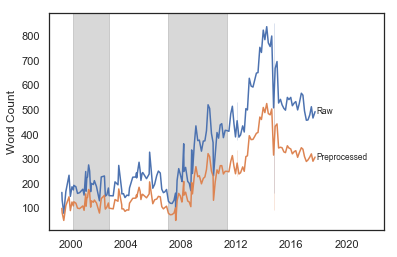

In [11]:
data = pd.DataFrame({'Year': x, 'Raw':raw_doc_length, 'Preprocessed':doc_length})
ax1=sns.lineplot(x='Year', y='Raw', data=data)
ax2=sns.lineplot(x='Year', y='Preprocessed', data=data)
ax1.set(xlabel ='', ylabel='Word Count')
ax2.set(xlabel ='', ylabel='Word Count')
ax1.text(x=date2num(data["Year"].iloc[-1])+30, y=data['Raw'].iloc[-1], s="Raw", 
         horizontalalignment='left', size='small', verticalalignment='center')
ax2.text(x=date2num(data["Year"].iloc[-1])+30, y=data['Preprocessed'].iloc[-1], s="Preprocessed", 
         horizontalalignment='left', size='small', verticalalignment='center')
# Shade in early 2000s crisis
ax2.axvspan(x[7], x[32], alpha=0.30, color='gray')
# Shade in global financial crisis
ax2.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.xlim(xmax=date2num(data["Year"].iloc[-1])+1826)
plt.savefig('images/document_length.png', dpi=300)
plt.show()

## Part 2: Feature Extraction

Next, we must extract features from the normalized text using the Sci-kit Learn package. We will extract them by transforming the pure text into a weighted document-term matrix. We create unigram and bigram representations. This allows us to look at the frequency of single words and contiguous pairs of words (unigram and bigram, respectively).

Our final weighted matrix is derived from the __Bag of Words Model (BOW)__. BOW is simply a matrix that collects the count of each unique term in the corpus in each document. It has the dimensions (number of documents x number of unique terms).

For a quick example, consider that we have three sentences, each representing a document:
1. I love dogs
2. I hate dogs and knitting
3. knitting is my hobby and my passion

An example of the Bag of Words model would be

<img src="images/bow.jpg" alt="Bag of Words Model" title="BoW model example" />

The Bag of Words model is a useful representation, but it can be improved upon. To make this representation more informative, we apply the term frequency-inverse document frequency weighting scheme to each element of the matrix. The idea behind this is to give the highest priority to words that occur frequently but in a low number of documents.

Term-frequency-inverse document frequency is represented by the following equation

$$ tf-idf = tf(t,d) \text{ x } idf(t, D) $$

with $tf(t,d)$ and $idf(t,D)$ representing the rewarding term frequency and penalizing document frequency terms, respectively.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
# Create unigram TF-IDF weighted matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=0.05, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(statements).toarray()
X_tfidf.shape

(159, 552)

In [14]:
# Create bigram TF-IDF weighted matrix
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.95)
X1_tfidf = bigram_tfidf_vectorizer.fit_transform(statements).toarray()
X1_tfidf.shape

(159, 1486)

## Part 3: Topic Modeling with Non-negative Matrix Factorization

<img src="images/NMF.jpg" alt="Visualization of NMF algorithm" title="Non-negative Matrix Factorization" />

- Developed by Lee and Seung (1999)
- Algorithm learns __parts-based representations__
- __W__ matrix tracks weights of topics in documents
- __H__ matrix tracks weights of unique terms in topics

Minimizes the following objective function:
$$ \dfrac{1}{2}||A - WH||_{F}^{2} = \dfrac{1}{2}\sum_{i=1}^{M}\sum_{j=1}^{N}(A_{ij}-(WH)_{ij})^{2} $$

In [15]:
# Import NMF from Scikit Learn and 
from sklearn.decomposition import NMF
from sklearn import metrics

In [16]:
# Create a function that prints the top words of a topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [17]:
# Create a function that prints the topics as a list
def print_topics(model, feature_names, n_top_words, n_components):
    topics=list(range(n_components))
    for topic_idx, topic in enumerate(model.components_):
        topics[topic_idx]=[str(feature_names[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

In [18]:
# Get the terms from the TF-IDF matrix
tfidf_feature_names_n1 = tfidf_vectorizer.get_feature_names()

In [19]:
# Estimate preliminary unigram NMF model with three topics
nmf = NMF(n_components=3, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf) # minimizes using kullback-leibler with unigrams
print_top_words(nmf, tfidf_feature_names_n1, 15)

Topic #0: inflation longer labor term condition policy price security fund run employment pace percent range agency
Topic #1: board growth approved action basis point discount reserve sustainable productivity belief risk demand price available
Topic #2: security credit financial reserve recovery level exceptionally purchase continue promote subdued facility billion condition housing



## Part 4: Parameter Selection for Non-negative Matrix Factorization

One of the main issues in topic modelling is deciding on the k parameter. This parameter is the number of topics to estimate in the model. Naturally, when we develop a topic model in the social sciences, we would like our topics to be defined and interpretable. Therefore, to automatically select the k parameter, we use __measures of topic coherence__. In general, topic coherence measures the semantic similarity between the top terms used to represent a topic. There exists numerous measures of coherency with the __most common measures being the $C_{UMass}$, $C_{UCI}$, and $C_{V}$__.

There exists a __distinction between extrinsic and intrinsic topic coherency measures__. Extrinsic measures use __external datasets__ to assess coherency or what we refer to as "background corpora." The argument behind these measures is that using the same dataset to assess coherency would reinforce noise or unusual word statistics. Standard measures for this is the $C_{UCI}$ and the $C_{V}$. Intrinsic measures simply use the main corpus and use empirical estimates of probabilities to define its measure. A standard intrinsic coherence measure is the $C_{UMass}$. All of these measures are openly available in the gensim package.

Since there are no suitable background sources of communication for the FOMC statements, we use $C_{UMass}$ coherency developed by Mimno et al. (2011). Specifically, it measures the ability of a higher weighted word in prediciting a lower weighted word. The equation follows

$$ C_{UMass}(w_i, w_j)^{(t)} = \dfrac{2}{N(N-1)}\sum_{i=2}^{N}\sum_{j=1}^{i-1}log\dfrac{P(w_{i}^{(t)},w_{j}^{(t)}) + \epsilon}{P(w_{j}^{(t)})} $$

In [20]:
# Retrieve modules to set corpous and get coherence. Show logging details to see progress.
from gensim import corpora, models

In [21]:
# Tokenize each statement, add terms to dictionary, and build main corpus
for i in range(n):
    statements[i] = CountVectorizer().build_tokenizer()(statements[i])
dictionary=corpora.Dictionary(statements)
corpus=[dictionary.doc2bow(doc) for doc in statements]

In [22]:
# Parameter selection using intrinsic coherence measure, u_mass. This measure uses the main corpus, which has its issues according to XXX paper
end_k=30
coherencenmf=[]
for k in range(3,end_k+1):
    n_components=k
    nmf = NMF(n_components=n_components, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
    topics=print_topics(nmf, tfidf_feature_names_n1, 15, n_components)
    cm_NMF = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencenmf.append(cm_NMF.get_coherence())
    print('k= %d' % k)
    print_top_words(nmf, tfidf_feature_names_n1, 15)

k= 3
Topic #0: inflation longer labor term condition policy price security fund run employment pace percent range agency
Topic #1: board growth approved action basis point discount reserve sustainable productivity belief risk demand price available
Topic #2: security credit financial reserve recovery level exceptionally purchase continue promote subdued facility billion condition housing

k= 4
Topic #0: inflation longer labor term condition policy security fund price percent employment range run pace agency
Topic #1: board approved basis action point growth discount reserve bank request related submitted director governor taking
Topic #2: security credit recovery level reserve financial exceptionally subdued purchase continue low promote facility billion resource
Topic #3: jr growth belief monetary policy available sustainable circumstance roger susan ferguson bies gramlich edward vice

k= 5
Topic #0: inflation longer labor term condition security employment percent policy range run ag

k= 13
Topic #0: inflation longer employment term labor appropriate policy pace objective maximum run consistent purchase month security
Topic #1: board approved basis point action discount request related submitted director governor taking bank reserve york
Topic #2: credit reserve security purchase facility financial billion period housing lending extended likely light condition backed
Topic #3: jr roger ferguson susan bies gramlich monetary edward vice mark olson robert bernanke ben unchanged
Topic #4: inflation moderate likely growth depend recent pressure fund evolution reflecting housing implied core utilization energy
Topic #5: economy may long weighted generate mainly weakness foreseeable information future background percent available reduction goal
Topic #6: range expected fund measure condition labor percent gradual actual strengthen normalization import based security energy
Topic #7: consistent level recovery mandate holding price subdued low adjust security utilization dep

k= 18
Topic #0: inflation longer term security pace employment policy objective purchase labor month appropriate run maximum agency
Topic #1: board approved basis action point discount bank request related reserve director submitted governor taking york
Topic #2: credit purchase reserve security period financial billion facility light mortgage condition backed agency overall housing
Topic #3: jr ferguson bies roger susan gramlich edward vice mark olson monetary robert bernanke ben kohn
Topic #4: inflation moderate likely growth depend recent pressure housing risk fund utilization quarter expand incoming target
Topic #5: background may weighted generate long mainly available demand weakness foreseeable economy future toward percent information
Topic #6: expected range fund measure condition labor percent actual gradual strengthen energy adjustment based import balance
Topic #7: level consistent recovery mandate price subdued holding utilization security low adjust stable review equipmen

k= 22
Topic #0: inflation longer security term agency purchase objective policy maximum mortgage employment pace run labor consistent
Topic #1: board approved basis action point discount reserve bank request submitted director governor related taking york
Topic #2: credit purchase security reserve billion mortgage financial condition light overall agency backed facility housing tool
Topic #3: jr roger susan ferguson bies gramlich vice edward olson mark monetary robert bernanke ben kohn
Topic #4: inflation moderate likely growth housing high depend recent fund incoming keep time risk quarter utilization
Topic #5: available demand background weighted generate mainly may long weakness foreseeable future toward economy heightened percent
Topic #6: expected range fund measure condition actual gradual labor percent adjustment strengthen energy based balance realized
Topic #7: level consistent recovery mandate price holding utilization subdued adjust security low review expectation nonresiden

k= 25
Topic #0: inflation longer term security policy labor agency objective pace run maximum month employment mortgage consistent
Topic #1: board approved basis action point discount reserve bank request submitted director related taking governor york
Topic #2: credit purchase reserve security period extended housing financial condition facility backed likely lending billion mortgage
Topic #3: jr susan ferguson roger bies gramlich vice edward olson mark monetary robert ben bernanke donald
Topic #4: inflation moderate likely growth housing fund pressure keep depend incoming high recent risk quarter seems
Topic #5: available demand background generate weighted mainly foreseeable future may long heightened economy growth information toward
Topic #6: expected fund range actual measure strengthen condition gradual percent labor based adjustment realized energy activity
Topic #7: level consistent recovery mandate holding price subdued adjust low utilization review stable regularly unemploym

k= 28
Topic #0: inflation longer security term agency employment policy objective maximum run pace labor consistent percent purchase
Topic #1: board approved basis action point discount reserve bank request director submitted related governor taking york
Topic #2: credit purchase reserve security light billion condition mortgage agency overall financial housing employ tool time
Topic #3: jr ferguson susan roger bies gramlich vice edward mark olson robert bernanke ben kohn donald
Topic #4: inflation moderate likely growth pressure high depend keep housing utilization recent incoming seems evolution risk
Topic #5: available demand background weighted generate foreseeable mainly long future economy may heightened toward information percent
Topic #6: expected fund range condition measure actual labor percent gradual strengthen adjustment energy based balance activity
Topic #7: level recovery consistent mandate price utilization holding subdued adjust security low nonresidential expectation

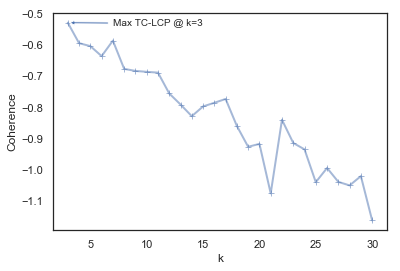

In [23]:
# Plot the coherence over the different 'k' selections
end_k=30
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencenmf, 'b+-', linewidth=2, label='UMass Coherency', alpha=0.5, markevery=1)
ax.set_xlabel('k')
ax.set_ylabel('Coherence')
ax.annotate('Max TC-LCP @ k=3', 
             xy=(3, -0.53001054467878117),  
             xycoords='data',
             xytext=(7, -0.54),
             arrowprops=dict(arrowstyle="simple"))
plt.savefig('images/UMassNMF.png', dpi=300)
plt.show()

Based on the three extrinsic coherency measures using the FOMC minutes as a background corpus, there is a consensus to estimate the model with k=3 as this gives the highest level of coherency. Therefore, we perform NMF with three components below and look to give an interpretation of these topics.

In [24]:
best_nmf = NMF(n_components=3, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=10000).fit(X_tfidf)
print_top_words(best_nmf, tfidf_feature_names_n1, 15)
best_topics=print_topics(best_nmf, tfidf_feature_names_n1, 15, 3)

Topic #0: inflation longer labor term condition policy price security fund run employment pace percent range agency
Topic #1: board growth approved action basis point discount reserve sustainable productivity belief risk demand price available
Topic #2: security credit financial reserve recovery level exceptionally purchase continue promote subdued facility billion condition housing



I believe that the topic model performed well in the analysis of the FOMC statements as each topic is clearly interpretable. The first topic represents "policy objectives" as it includes descriptors like inflation, security, employment, and price. These are words related to the Federal Reserve's explicit mandates. The second topic is related to "monetary policy tools and targets." Finally, the third topic is related to "financial markets." These are three topics that are useful for further analysis.

In [25]:
# Extract the weights for the model for later regression analysis.
W = best_nmf.fit_transform(X_tfidf) # topic-document weights
H = best_nmf.components_ # word-topic weights

In [26]:
# Dimensions of the W matrix
W.shape

(159, 3)

## Part 5: Visualization of the NMF Topics

In this section, we plot the topic-document weights as a function of the document dates. This analysis serves the purpose of providing a time series of topic weights to see the intensity of topics over time. This analysis is useful to map historical events back to the output of the topic model as this will provide even more validity to the performance of these models.

In [27]:
# Create dates and NMF weight variables
y1 = W[:,0]
y2 = W[:,1]
y3 = W[:,2]

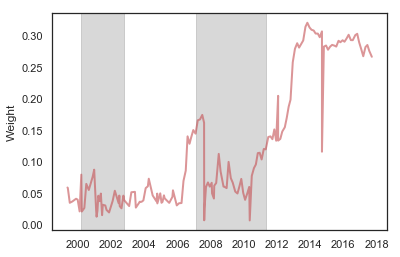

In [28]:
# Plot topic 1 weights as a time series
fig, ax = plt.subplots()
ax.plot(x, y1, 'r-', linewidth=2, label='topic 1', alpha=0.6)
ax.set_ylabel('Weight')
ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.savefig('images/NMFWeights1.png', dpi=300)
plt.show()

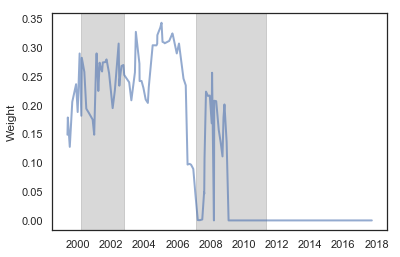

In [29]:
# Plot topic 2 weights as a time series
fig, ax = plt.subplots()
ax.plot(x, y2, 'b-', linewidth=2, label='topic 2', alpha=0.6)
ax.set_ylabel('Weight')
ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.savefig('images/NMFWeights2.png', dpi=300)
plt.show()

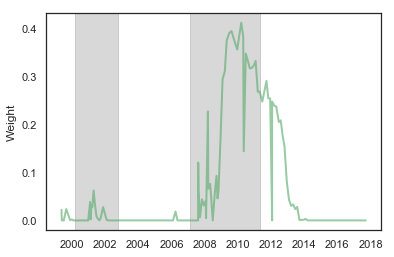

In [30]:
# Plot topic 3 weights as a time series
fig, ax = plt.subplots()
ax.plot(x, y3, 'g-', linewidth=2, label='topic 3', alpha=0.6)
ax.set_ylabel('Weight')
ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.savefig('images/NMFWeights3.png', dpi=300)
plt.show()

In this section, I create word clouds for the topics using the wordcloud package. This is good for representing topics in a coherent and clear way. It is also possible to use wordle.net, which is an online, interactive wordcloud creator. It provides more visually appealing wordclouds than the wordcloud package but is not capable of being integrated into Python. It is highly suggested to use that for creating wordclouds to be included in publications.

In [31]:
from wordcloud import WordCloud

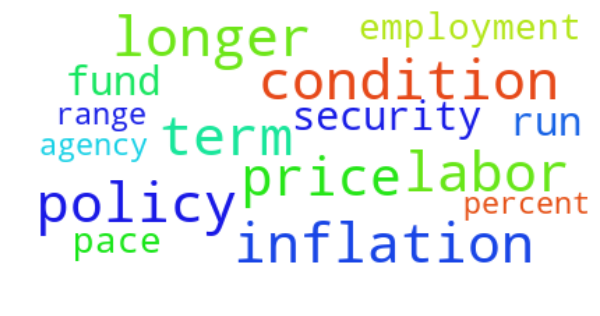

In [32]:
topic1 = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(best_topics[0]))
plt.figure(figsize=(10, 6))
plt.imshow(topic1, interpolation="bilinear")
plt.axis("off")
plt.savefig('images/NMF Theme 1.png', dpi=300)
plt.show()

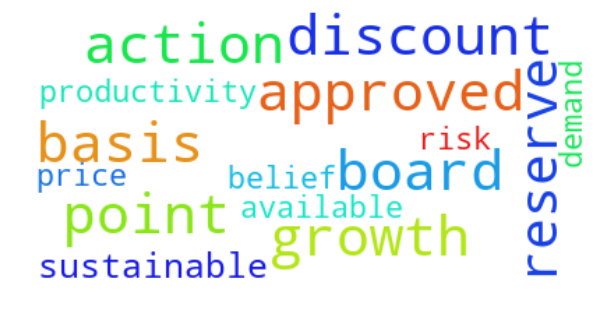

In [33]:
topic2 = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(best_topics[1]))
plt.figure(figsize=(10, 6))
plt.imshow(topic2, interpolation="bilinear")
plt.axis("off")
plt.savefig('images/NMF Theme 2.png', dpi=300)
plt.show()

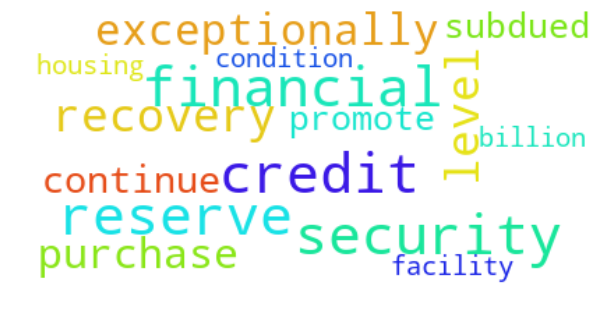

In [34]:
topic3 = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(best_topics[2]))
plt.figure(figsize=(10, 6))
plt.imshow(topic3,  interpolation="bilinear")
plt.axis("off")
plt.savefig('images/NMF Theme 3.png', dpi=300)
plt.show()

In [35]:
# Save the weights to a csv file
W = pd.DataFrame(W)
W.to_csv("results/weights.csv")

## Part 6: Topic Modeling using Latent Dirichelet Allocation

Latent Dirichlet Allocation (LDA) is a probabilistic topic model. What this means is that LDA depends on probabilities to estimate the the parameters of interest. In this model we estimate two key parameters of interest: $\theta_d$ and $\beta_k$.

$\theta_d$ is the analog of the $W$ matrix in NMF and looks at the topic share in the document $d$, while $\beta_k$ is the analog of the $H$ matrix in NMF and estimates the weights of the terms in the topics.

Details about LDA can be found in the original paper by Blei et al. (2003).

In [36]:
# Import LDA model
from sklearn.decomposition import LatentDirichletAllocation

In [37]:
# Parameter selection using intrinsic coherence measure, u_mass.
coherencelda=[]
end_k = 30
for k in range(3,end_k+1):
    n_components=k
    ldamodel = LatentDirichletAllocation(doc_topic_prior = 50/n_components, topic_word_prior = 0.025, n_components=n_components, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
    topics=print_topics(ldamodel, tfidf_feature_names_n1, 15, n_components)
    cm_LDA = models.coherencemodel.CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherencelda.append(cm_LDA.get_coherence())
    print('k= %d' % k)
    print_top_words(ldamodel, tfidf_feature_names_n1, 15)
print(coherencelda)

k= 3
Topic #0: inflation point longer policy term board toward maintain security basis accommodative growth however maximum month
Topic #1: percent inflation continue level development security outlook approved productivity purchase sustainable housing growth pace continues
Topic #2: inflation time price information expected condition belief risk today may mortgage consistent reserve accommodation potential

k= 4
Topic #0: inflation longer toward basis accommodative month policy run however maintain board resource maximum security billion
Topic #1: percent continue development inflation pace continues security purchase agency productivity business housing keep growth decline
Topic #2: inflation expected risk time information condition today belief consistent price since may credit fund accommodation
Topic #3: level term inflation moderate measure economy mortgage remains available approved underlying indicator reserve recent decided

k= 5
Topic #0: longer toward inflation accommodative

k= 12
Topic #0: maximum longer toward range accommodative adjustment policy balance incoming current long inflation however believe louis
Topic #1: agency percent productivity continue anticipates sustainable business decline rise reflecting roughly chicago labor attainment principal
Topic #2: consistent information price belief potential spending governor fund holding may dual expected time today warrant
Topic #3: level available indicator underlying expectation term economy moderate monitor program appropriate commodity mortgage nonetheless unemployment
Topic #4: decided financial remain increase housing run basis keep year accommodation lower foreseeable appears activity next
Topic #5: risk outlook maintain demand condition future taking basis promote background credit including additional balanced reduction
Topic #6: security continues remains inflation objective pressure expects somewhat labor expand effect francisco continued financial take
Topic #7: growth purchase bank approved

k= 17
Topic #0: longer maximum accommodative policy long adjustment incoming current inflation agency louis providing balance size keeping
Topic #1: agency continue percent business productivity decline reflecting rise roughly chicago principal facility view tight extended
Topic #2: consistent information belief holding potential may time dual still fixed timing though dallas inflation governor
Topic #3: level available indicator underlying appropriate unemployment economy moderate term commodity monitor received bies substantial maturing
Topic #4: remain decided accommodation lower year foreseeable increase appears activity next san keep change liquidity gradually
Topic #5: maintain condition demand future resource including term balanced reduction consumer indicates even weak heightened risk
Topic #6: security pressure remains continues continued expects inflation somewhat expand francisco take generate labor data measured
Topic #7: growth approved reserve purchase target since monet

k= 21
Topic #0: maximum accommodative longer policy long adjustment incoming current louis providing size keeping statutory agency vice
Topic #1: percent continue agency productivity business rise roughly york facility tight gramlich improve inflationary easing import
Topic #2: consistent information belief may potential dual still holding fixed timing though dallas today account employ
Topic #3: level available underlying appropriate unemployment economy monitor commodity received bies substantial highly act extent discount
Topic #4: remain decided accommodation lower foreseeable next san keep year change activity appears liquidity gradually increase
Topic #5: maintain demand future resource condition including balanced reduction consumer indicates even heightened become sustain aggregate
Topic #6: pressure remains continues continued somewhat expand security inflation francisco take generate data measured edward realized
Topic #7: growth approved reserve purchase since new downside t

k= 24
Topic #0: maximum accommodative longer adjustment incoming current policy louis providing keeping statutory vice solid trend ensure
Topic #1: percent continue agency productivity business york rise roughly facility tight gramlich inflationary import easing kohn
Topic #2: consistent information belief may potential dual holding still today fixed dallas account employ march already
Topic #3: level available underlying economy monitor commodity unemployment discount received bies substantial highly act extent inventory
Topic #4: remain decided accommodation lower foreseeable san next change year liquidity gradually appears olson gain closely
Topic #5: maintain demand future resource condition including balanced reduction consumer even heightened become sustain aggregate sign
Topic #6: pressure continues continued somewhat expand inflation francisco take generate security data measured realized provide last
Topic #7: growth approved purchase since target monetary circumstance downsid

k= 27
Topic #0: maximum accommodative adjustment incoming current louis providing longer keeping policy statutory vice solid trend ensure
Topic #1: continue percent agency productivity business york rise roughly facility tight gramlich inflationary import easing kohn
Topic #2: consistent information belief may potential dual still holding today fixed dallas account governor mainly already
Topic #3: level available underlying economy monitor unemployment commodity received bies substantial highly act extent inventory intermeeting
Topic #4: remain decided accommodation lower foreseeable san year next change liquidity gradually olson gain closely expanding
Topic #5: maintain demand future resource including balanced reduction consumer even heightened become sustain aggregate sign relative
Topic #6: pressure continues continued somewhat expand take generate inflation data francisco security measured realized provide last
Topic #7: growth purchase approved target since circumstance gradual 

k= 30
Topic #0: accommodative adjustment incoming current louis longer providing keeping vice solid trend ensure transitory relatively march
Topic #1: continue agency percent business productivity york rise roughly facility tight gramlich inflationary import easing together
Topic #2: consistent information belief may potential dual still fixed dallas account today mainly governor already significantly
Topic #3: level available underlying economy monitor unemployment commodity received bies substantial highly act extent inventory intermeeting
Topic #4: remain decided accommodation lower year san next change liquidity gradually appears olson gain closely expanding
Topic #5: maintain demand future resource including reduction consumer even heightened become sustain aggregate sign relative equipment
Topic #6: pressure continues somewhat generate data francisco security measured realized provide last inflation robert composition reinvesting
Topic #7: growth purchase since target circumstanc

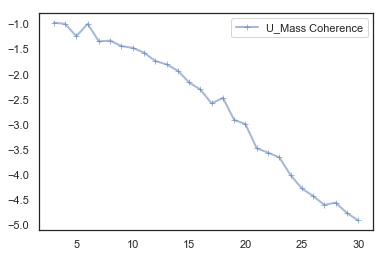

In [38]:
# Plot the coherence over the different 'k' selections
fig, ax = plt.subplots()
ax.plot(list(range(3, end_k+1)), coherencelda, 'b+-', linewidth=2, label='U_Mass Coherence', alpha=0.5, markevery=1)
ax.legend()
plt.show()

In [39]:
best_lda = LatentDirichletAllocation(doc_topic_prior = 50/3, topic_word_prior = 0.025, n_components=3, max_iter=10, learning_method='batch', random_state=0).fit(X_tfidf)
print_top_words(best_lda, tfidf_feature_names_n1, 15)
best_topics1=print_topics(best_lda, tfidf_feature_names_n1, 15, 3)

Topic #0: inflation point longer policy term board toward maintain security basis accommodative growth however maximum month
Topic #1: percent inflation continue level development security outlook approved productivity purchase sustainable housing growth pace continues
Topic #2: inflation time price information expected condition belief risk today may mortgage consistent reserve accommodation potential



## Part 7: Visualization of the LDA Topics

In [40]:
# Get probabilities from LDA model
P = best_lda.transform(X_tfidf) # Get a topic-document probability matrix
P

array([[ 0.33777447,  0.32967423,  0.33255129],
       [ 0.32936235,  0.3234319 ,  0.34720575],
       [ 0.33373543,  0.33748509,  0.32877948],
       [ 0.330034  ,  0.32884474,  0.34112125],
       [ 0.32729878,  0.33382137,  0.33887985],
       [ 0.33662436,  0.33184858,  0.33152706],
       [ 0.33403838,  0.33106911,  0.33489251],
       [ 0.31993657,  0.34812843,  0.33193499],
       [ 0.33718107,  0.32952369,  0.33329524],
       [ 0.3318337 ,  0.32639804,  0.34176826],
       [ 0.32351835,  0.33771581,  0.33876584],
       [ 0.32777877,  0.33237648,  0.33984475],
       [ 0.3241819 ,  0.33598055,  0.33983755],
       [ 0.34206989,  0.3213574 ,  0.33657271],
       [ 0.32741741,  0.33062326,  0.34195933],
       [ 0.33885397,  0.32657124,  0.3345748 ],
       [ 0.33245646,  0.32951493,  0.33802861],
       [ 0.3292247 ,  0.33629833,  0.33447697],
       [ 0.32977747,  0.33254611,  0.33767642],
       [ 0.33866993,  0.33140288,  0.32992719],
       [ 0.34055666,  0.32654141,  0.332

In [41]:
# Create variables of probabilities
y1_1 = P[:,0]
y1_2 = P[:,1]
y1_3 = P[:,2]

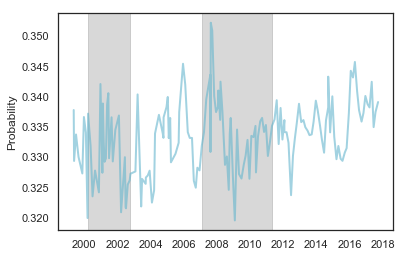

In [42]:
# Plot topic 1 probabilities as a time series
fig, ax = plt.subplots()
ax.plot(x, y1_1, 'c-', linewidth=2, label='topic 1 probability', alpha=0.6)
ax.set_ylabel('Probability')
ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.savefig('images/LDAProbabilities1.png', dpi=300)
plt.show()

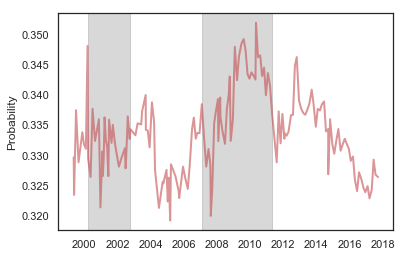

In [43]:
# Plot topic 2 probabilities as a time series
fig, ax = plt.subplots()
ax.plot(x, y1_2, 'r-', linewidth=2, label='topic 2 probability', alpha=0.6)
ax.set_ylabel('Probability')
ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.savefig('images/LDAProbabilities2.png', dpi=300)
plt.show()

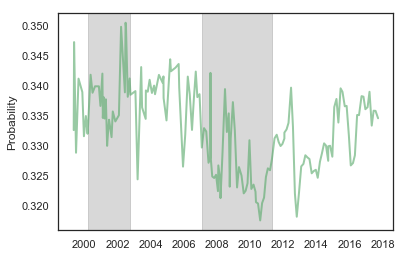

In [44]:
# Plot topic 3 probabilities as a time series
fig, ax = plt.subplots()
ax.plot(x, y1_3, 'g-', linewidth=2, label='topic 3 probability', alpha=0.6)
ax.set_ylabel('Probability')
ax.axvspan(x[7], x[32], alpha=0.30, color='gray')
ax.axvspan(x[65], x[105], alpha=0.30, color='gray')
plt.savefig('images/LDAProbabilities3.png', dpi=300)
plt.show()

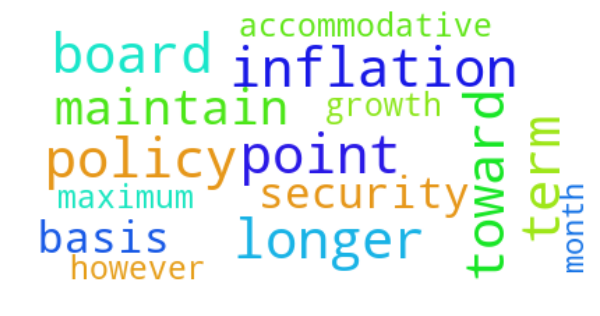

In [45]:
topic1_1 = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(best_topics1[0]))
plt.figure(figsize=(10, 6))
plt.imshow(topic1_1, interpolation="bilinear")
plt.axis("off")
plt.savefig('images/LDA Theme 1.png', dpi=300)
plt.show()

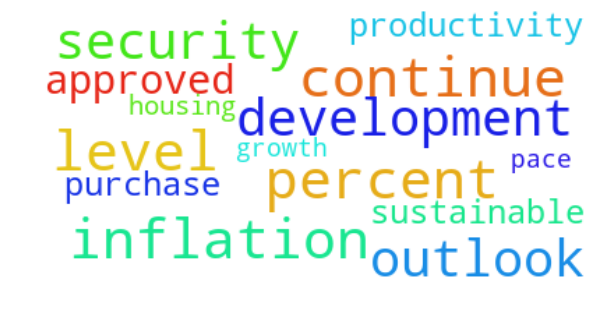

In [46]:
topic1_2 = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(best_topics1[1]))
plt.figure(figsize=(10, 6))
plt.imshow(topic1_2, interpolation="bilinear")
plt.axis("off")
plt.savefig('images/LDA Theme 2.png', dpi=300)
plt.show()

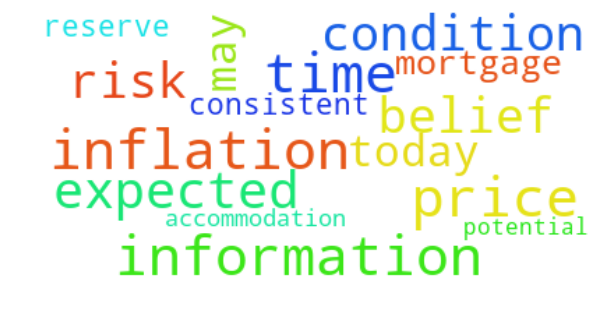

In [47]:
topic1_3 = WordCloud(ranks_only=True, max_font_size=40, background_color="white").generate(' '.join(best_topics1[2]))
plt.figure(figsize=(10, 6))
plt.imshow(topic1_3, interpolation="bilinear")
plt.axis("off")
plt.savefig('images/LDA Theme 3.png', dpi=300)
plt.show()

In [48]:
P = pd.DataFrame(P)
P.to_csv("results/probabilities.csv")

### Brief Comparison of LDA and NMF Coherency

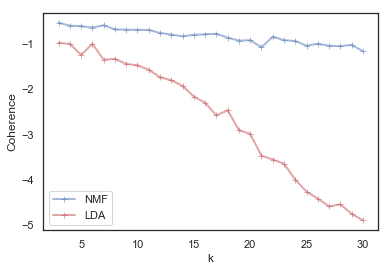

In [49]:
fig, ax = plt.subplots()
ax.plot(list(range(3, 30+1)), coherencenmf, 'b+-', linewidth=2, label='NMF', alpha=0.5, markevery=1)
ax.plot(list(range(3, 30+1)), coherencelda, 'r+-', linewidth=2, label='LDA', alpha=0.5, markevery=1)
ax.legend()
ax.set_ylabel('Coherence')
ax.set_xlabel('k')
plt.savefig('images/nmf_lda_coherence.png', dpi=300)
plt.show()

## Part 8: Establishing Polarity in FOMC Statements

In this section, I will estabish the polarity/sentiment of the FOMC statements. I will use a dictionary-based method that uses the Loughran and McDonald (2011) financial dictionary. This dataset is advantageous as it is a discipline-specific dictionary which is more relevant to central banking language and also contains terminology that would be familiar to financial market participants. Additionally, this provides us a systematic benchmark for establishing polarity that does not require us to choose a list of words that are relevant, which would influence the outcome of our models. The categories are entitled 'negative', 'positive', 'uncertainty', 'litigious', 'modal', and 'constraining.'

The master dictionary and list of words by sentiment can be found at this [website](http://sraf.nd.edu/textual-analysis/resources/).

In [50]:
# Read in pdf file of the list of negative financial terms
pdfFileObj = open('dictionaries/LM_Negative.pdf','rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
pdfReader.numPages

52

In [51]:
# Collect words from each page and lowercase them
negative=[]
for pageNum in range(0, pdfReader.numPages):
    pageObj = pdfReader.getPage(pageNum)
    negative.append(CountVectorizer().build_tokenizer()(pageObj.extractText().lower()))
negative

[['loughran',
  'mcdonald',
  'sentiment',
  'word',
  'lists',
  'negative',
  'abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident'],
 ['accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'ac

In [52]:
# delete the first six terms that are simply part of the list description
del negative[0][0:6]
negative

[['abandon',
  'abandoned',
  'abandoning',
  'abandonment',
  'abandonments',
  'abandons',
  'abdicated',
  'abdicates',
  'abdicating',
  'abdication',
  'abdications',
  'aberrant',
  'aberration',
  'aberrational',
  'aberrations',
  'abetting',
  'abnormal',
  'abnormalities',
  'abnormality',
  'abnormally',
  'abolish',
  'abolished',
  'abolishes',
  'abolishing',
  'abrogate',
  'abrogated',
  'abrogates',
  'abrogating',
  'abrogation',
  'abrogations',
  'abrupt',
  'abruptly',
  'abruptness',
  'absence',
  'absences',
  'absenteeism',
  'abuse',
  'abused',
  'abuses',
  'abusing',
  'abusive',
  'abusively',
  'abusiveness',
  'accident'],
 ['accidental',
  'accidentally',
  'accidents',
  'accusation',
  'accusations',
  'accuse',
  'accused',
  'accuses',
  'accusing',
  'acquiesce',
  'acquiesced',
  'acquiesces',
  'acquiescing',
  'acquit',
  'acquits',
  'acquittal',
  'acquittals',
  'acquitte',
  'acquitting',
  'adulterate',
  'adulterated',
  'adulterating',
  

In [53]:
# Calculate the sum of negative terms within each statement
neg_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    neg_count = 0
    fomc = statements[i]
    for word in fomc:
        for neg in negative:
            if((word in set(neg)) == True):
                neg_count += 1
    neg_sum[i] = neg_count

In [54]:
# Transform negative sum list into a numpy array
neg_sum = np.asarray(neg_sum)
neg_sum

array([ 1,  4,  4,  3,  4,  3,  3,  0,  3,  4,  0,  1,  2,  9,  6,  3,  2,
        5,  9,  5,  4,  6,  5,  4,  3,  4,  3,  1,  0,  0,  4,  2,  1,  0,
        1,  4,  2,  2,  3,  2,  2,  2,  5,  0,  0,  0,  1,  0,  0,  2,  0,
        1,  0,  0,  1,  7,  1,  0,  1,  1,  1,  1,  0,  1,  1,  0,  2,  3,
        2,  4,  0,  3,  5,  6,  4,  4,  2,  0,  6,  5,  4,  4,  7, 12,  8,
        8,  6,  8, 10,  7,  7,  9,  7,  8,  5,  7,  8,  2,  6,  5,  7, 11,
       13, 10,  4,  4, 11, 13, 11,  8,  6,  9,  9,  8,  8, 12, 11,  9,  9,
        9,  9,  8,  7,  9,  9, 11, 10, 13, 11, 10,  8,  5,  9,  8,  0,  9,
        9, 10,  9, 10,  5,  6,  7,  6,  7, 10,  4,  5, 10,  6,  5,  4,  5,
        3,  1,  5,  3,  3,  7])

In [55]:
# Calculate the proportion of negative words in each statement
negativity_proportion = neg_sum/doc_length
negativity_proportion

array([ 0.01020408,  0.05      ,  0.08163265,  0.02752294,  0.02758621,
        0.03370787,  0.02419355,  0.        ,  0.024     ,  0.03361345,
        0.        ,  0.01030928,  0.01851852,  0.1       ,  0.03821656,
        0.02803738,  0.01438849,  0.03496503,  0.05142857,  0.0308642 ,
        0.03883495,  0.04651163,  0.04065041,  0.03030303,  0.025     ,
        0.05063291,  0.02173913,  0.00662252,  0.        ,  0.        ,
        0.03883495,  0.01666667,  0.01010101,  0.        ,  0.00746269,
        0.03149606,  0.01129944,  0.01769912,  0.03125   ,  0.02083333,
        0.02325581,  0.02173913,  0.05494505,  0.        ,  0.        ,
        0.        ,  0.00653595,  0.        ,  0.        ,  0.01190476,
        0.        ,  0.00645161,  0.        ,  0.        ,  0.00636943,
        0.03398058,  0.00854701,  0.        ,  0.00735294,  0.00680272,
        0.00689655,  0.00952381,  0.        ,  0.00990099,  0.00934579,
        0.        ,  0.02777778,  0.04109589,  0.02531646,  0.04

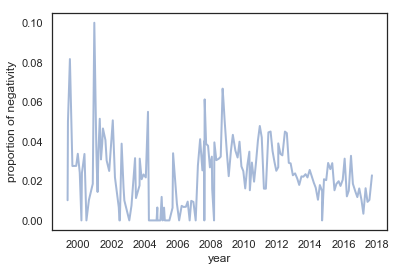

In [56]:
# Plot the proportion of negativity as a time series
fig, ax = plt.subplots()
ax.plot(x, negativity_proportion, 'b-', linewidth=2, label='Negativity', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of negativity')
plt.show()

In [57]:
# Export the proportion of negativity to csv file
NegProp = pd.DataFrame(negativity_proportion)
NegProp.to_csv("results/negativity.csv")

## Part 9: Calculating Uncertainty in FOMC Statements

In this section, I look to calculate a level of uncertainty in each document. Similar to the previous section, I use a dictionary-based method incorporating the sentimental list of words provided in the financial dictionary by Loughran and McDonald (2011). This allows me to come up with a measure of uncertainty within the statements. The literature looks at uncertainty as a main contributor to financial market volatility, which is channeled into risk premia. Using this measure, we can look at the influence of uncertainty on the yield curve.

In [58]:
# Read in pdf file of list of uncertain financial terms
pdfFileObj2 = open('dictionaries/LM_Uncertainty.pdf','rb')
pdfReader2 = PyPDF2.PdfFileReader(pdfFileObj2)
pdfReader2.numPages

7

In [59]:
# Collect the uncertainty terms on each page into a list
uncertainty=[]
for pageNum in range(0, pdfReader2.numPages):
    pageObj2 = pdfReader2.getPage(pageNum)
    uncertainty.append(CountVectorizer().build_tokenizer()(pageObj2.extractText().lower()))
uncertainty

[['loughran',
  'mcdonald',
  'sentiment',
  'word',
  'lists',
  'uncertainty',
  'abeyance',
  'abeyances',
  'almost',
  'alteration',
  'alterations',
  'ambiguities',
  'ambiguity',
  'ambiguous',
  'anomalies',
  'anomalous',
  'anomalously',
  'anomaly',
  'anticipate',
  'anticipated',
  'anticipates',
  'anticipating',
  'anticipation',
  'anticipations',
  'apparent',
  'apparently',
  'appear',
  'appeared',
  'appearing',
  'appears',
  'approximate',
  'approximated',
  'approximately',
  'approximates',
  'approximating',
  'approximation',
  'approximations',
  'arbitrarily',
  'arbitrariness',
  'arbitrary',
  'assume',
  'assumed',
  'assumes',
  'assuming',
  'assumption',
  'assumptions',
  'believe',
  'believed',
  'believes',
  'believing'],
 ['cautious',
  'cautiously',
  'cautiousness',
  'clarification',
  'clarifications',
  'conceivable',
  'conceivably',
  'conditional',
  'conditionally',
  'confuses',
  'confusing',
  'confusingly',
  'confusion',
  'conti

In [60]:
# Delete the first six terms that are simply part of the list description
del uncertainty[0][0:6]
uncertainty

[['abeyance',
  'abeyances',
  'almost',
  'alteration',
  'alterations',
  'ambiguities',
  'ambiguity',
  'ambiguous',
  'anomalies',
  'anomalous',
  'anomalously',
  'anomaly',
  'anticipate',
  'anticipated',
  'anticipates',
  'anticipating',
  'anticipation',
  'anticipations',
  'apparent',
  'apparently',
  'appear',
  'appeared',
  'appearing',
  'appears',
  'approximate',
  'approximated',
  'approximately',
  'approximates',
  'approximating',
  'approximation',
  'approximations',
  'arbitrarily',
  'arbitrariness',
  'arbitrary',
  'assume',
  'assumed',
  'assumes',
  'assuming',
  'assumption',
  'assumptions',
  'believe',
  'believed',
  'believes',
  'believing'],
 ['cautious',
  'cautiously',
  'cautiousness',
  'clarification',
  'clarifications',
  'conceivable',
  'conceivably',
  'conditional',
  'conditionally',
  'confuses',
  'confusing',
  'confusingly',
  'confusion',
  'contingencies',
  'contingency',
  'contingent',
  'contingently',
  'contingents',
  

In [61]:
# Calculate the sum of uncertain terms within each statement
uncertain_sum = list(range(0, len(statements)))
for i in range(0, len(statements)):
    uncertain_count = 0
    fomc = statements[i]
    for word in fomc:
        for unc in uncertainty:
            if((word in set(unc)) == True):
                uncertain_count += 1
    uncertain_sum[i] = uncertain_count

In [62]:
# Transform the uncertainty sum list into a numpy array
uncertain_sum = np.asarray(uncertain_sum)
uncertain_sum

array([ 3,  4,  2,  1,  4,  4,  3,  4,  3,  3,  7,  4,  7,  5,  4,  5,  4,
       11, 10,  9,  6,  3,  3,  7,  7,  4,  2,  4,  3,  2,  3,  5,  2,  3,
        9,  5,  4,  7,  5,  6,  5,  7,  6,  7,  4,  3,  5,  3,  3,  2,  3,
        5,  2,  2,  3,  6,  4,  5,  7,  5,  5,  4,  5,  5,  5,  9,  4,  4,
        4,  6,  2,  3,  3,  7,  4,  5,  3,  0,  3,  3,  5,  3,  4,  4,  2,
        1,  7,  5,  6,  4,  4,  5,  7,  7,  7,  6,  6,  0,  7,  5,  5,  7,
        5,  3,  5,  3,  4,  7,  5,  7,  7, 13,  5,  6,  7,  8,  7,  6,  6,
        9, 10, 10,  9,  8,  9, 11, 12,  8,  7, 10, 10,  9, 12, 15,  1, 14,
       13,  9,  9,  8, 10,  7,  9,  7,  4,  4,  4,  3,  4,  4,  6,  7,  6,
        6,  9,  7,  9,  7,  7])

In [63]:
# Calculate the proportion of uncertain words in each statement
uncertainty_proportion = uncertain_sum/doc_length
uncertainty_proportion

array([ 0.03061224,  0.05      ,  0.04081633,  0.00917431,  0.02758621,
        0.04494382,  0.02419355,  0.03703704,  0.024     ,  0.02521008,
        0.07070707,  0.04123711,  0.06481481,  0.05555556,  0.02547771,
        0.04672897,  0.02877698,  0.07692308,  0.05714286,  0.05555556,
        0.05825243,  0.02325581,  0.02439024,  0.0530303 ,  0.05833333,
        0.05063291,  0.01449275,  0.02649007,  0.02857143,  0.02105263,
        0.02912621,  0.04166667,  0.02020202,  0.03125   ,  0.06716418,
        0.03937008,  0.02259887,  0.0619469 ,  0.05208333,  0.0625    ,
        0.05813953,  0.07608696,  0.06593407,  0.05882353,  0.02877698,
        0.02142857,  0.03267974,  0.02097902,  0.01630435,  0.01190476,
        0.02238806,  0.03225806,  0.01290323,  0.0141844 ,  0.01910828,
        0.02912621,  0.03418803,  0.03759398,  0.05147059,  0.03401361,
        0.03448276,  0.03809524,  0.05208333,  0.04950495,  0.04672897,
        0.11538462,  0.05555556,  0.05479452,  0.05063291,  0.06

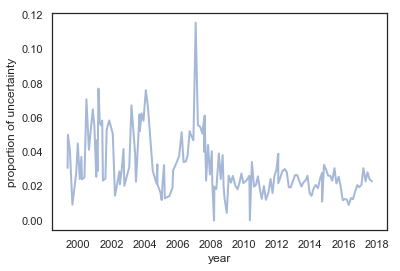

In [64]:
# Plot the proportion of uncertainty as a time series
fig, ax = plt.subplots()
ax.plot(x, uncertainty_proportion, 'b-', linewidth=2, label='Uncertainty', alpha=0.5, markevery=1)
ax.set_xlabel('year')
ax.set_ylabel('proportion of uncertainty')
plt.show()

In [65]:
# Export the uncertainty proportion to a csv file
UncertProp = pd.DataFrame(uncertainty_proportion)
UncertProp.to_csv("results/uncertainty.csv")

## Part 10: Regression Analysis

In [66]:
from pandas_datareader import data
import statsmodels.api as sm

In [67]:
# Want to look at influence of changes in topics
W_diff = W.diff() # w_diff = w(t) - w(t-1)
W_diff = np.asarray(W_diff)

In [68]:
# Set end dates
start_date = x[0]
end_date = x[-1]

In [69]:
vix = data.get_data_yahoo('^VIX', start_date, end_date)
vix.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1999-05-10,26.980000,25.730000,26.389999,26.620001,0,26.620001
1999-05-11,26.209999,25.330000,25.860001,25.620001,0,25.620001
1999-05-12,27.080000,26.059999,26.709999,26.129999,0,26.129999
1999-05-13,25.559999,24.760000,25.559999,25.020000,0,25.020000
1999-05-14,27.780001,26.480000,26.590000,26.860001,0,26.860001


In [70]:
# Set dependent variable as VIX at close
y = vix['Close']

In [71]:
# Construct X matrix
vix_dates = vix.index
statement_dates = x
X = np.zeros((len(y), W.shape[1]))
for i, vix_date in enumerate(vix_dates):
    for j, statement_date in enumerate(statement_dates):
        if int(date2num(vix_date)) == int(date2num(statement_date)):
            X[i,:] = W_diff[j,:]

In [72]:
# Estimate OLS
X_cons = sm.add_constant(X) # add column of ones/intercept
model = sm.OLS(y[1:], X_cons[1:,:]) # drop row with NaNs due to first differencing
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.021
Date:                Sat, 10 Nov 2018   Prob (F-statistic):              0.109
Time:                        05:54:39   Log-Likelihood:                -16501.
No. Observations:                4622   AIC:                         3.301e+04
Df Residuals:                    4618   BIC:                         3.304e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1386      0.127    159.196      0.0

### Finding:
In this extremely simple model, there evidence that more central bank __communication related to financial markets__ contributes to __increased stock market volatility__.

### Issue:
Model is underspecified and could be better. Many factors contribute to stock market volatility.